<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/advanced-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-3-1.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# NN Heston Model - Parameters Generation

In [8]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

from smt.sampling_methods import LHS
from sklearn.model_selection import train_test_split

This notebook is the first step in the presentation of a simple version of the Volatility Feature Approach (VFA). We start by generating a realistic synthetic dataset of vanilla option prices, using the **Heston model**, which will be used to train and evaluate a deep learning model. 

## Key Computation Steps

1. **Parameter Sampling**
- The notebook uses **Latin Hypercube Sampling (LHS)** to generate a diverse and efficient set of synthetic market scenarios.
- Each sample corresponds to a combination of option parameters: **moneyness (S/K), maturity, volatility, etc.**

2. **Option Pricing**
- For each sampled configuration, the notebook **computes the Heston Model price**.
- These prices represent the **target values** the model will later try to learn.

3. **Data Perturbation (Optional)**
- If noise level `EPS` is positive, **Gaussian noise** is added to the target prices to simulate **market imperfections** (e.g., liquidity effects, data errors).
- This helps train models that are more **robust to real-world distortions**.

4. **Train/Test Split**
- The dataset is randomly split into:
  - **Training set**: used to train a neural network
  - **Test/challenge set**: used to evaluate generalization
- Optionally, a **perturbed version** of the training set is used to increase noise robustness.

5. **Exploratory Visualizations**
- Scatter plots and histograms compare:
  - Clean vs. noisy prices
  - Distributions of training and test prices

6. **Export to Disk**
- Three CSV files are written:
  - `full_10000_MCA.csv`: full training set
  - `test_10000_MCA.csv`: test set without target prices
  - `trgt_10000_MCA.csv`: true prices for test set

These files serve as the **input for the deep learning model** trained in the next phase of the workflow.

## Generating Dataset

### Python support functions

#### Plotting Functions

In [9]:
def histo_dict(df, TAG = '0000'):
    keys = list(df.keys())
    LEN = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,6))
    for n in range(LEN):
        k     = keys[n]
        x     = df[k]
        lo   = np.min(x)
        hi   = np.max(x)
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x, density=True, facecolor='g', bins=bins)
        ax[n].set_title("%s (len=%d)" %(k,len(x)))
        n += 1
    
    #plt.savefig("pdf_%s.png" %TAG, format="png")
    plt.savefig("param_pdf.png", format="png")
    plt.show()


In [10]:
def histo_params( x, title = "None"):
    keys = list(x)
    LEN  = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,4))
    if not title == None: fig.suptitle(title)
    for n in range(LEN):
        tag  = keys[n]
        lo   = np.min(x[tag])
        hi   = np.max(x[tag])
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x[tag], density=True, facecolor='g', bins=bins)
        ax[n].set_title(tag)
        n += 1
    plt.subplots_adjust(left=.05, right=.95, bottom=.10, top=.80, wspace=.50)
    plt.show()


#### Pricing Functions

This is the pricing function for the Heston Model we use in this example. The `Heston` class and the `ft_opt` function are defined in the `Lib` module. For a complete description of the Heston model refer to the Computational Finance Lecture Notes of Pietro Rossi.

In [11]:
import math
import cmath
from math import *
import numpy as np

#      1 + g
#  ---------------------
#    1 + g exp( - gamma * T )
#
def arg_log( c_gmma, c_g, T):
    return (1.0 + c_g)/(1.0 + c_g*cmath.exp(-c_gmma*T))

#
#  C = 2 * log( (1 - g) / ( 1 - g e^{-gamma T } ) )/sigma^2
#  arg_log := (1 - g) / ( 1 - g e^{-gamma T } )
#
def C( c_gmma, c_g, sigma, T):
    c_psi = arg_log(c_gmma, c_g, T)
    return 2*cmath.log(c_psi)/pow(sigma,2)

#
# .5 ( v - v^2 )
#
def Lambda( c_v): 
    return .5*c_v - .5*c_v*c_v

#
# Gamma =  SQRT( kappa^2 + 2 L sigma^2 )
#
def Gamma( c_L, c_kappa, sigma):
    return cmath.sqrt(c_kappa*c_kappa + 2.*c_L*pow(sigma,2))
#
# g = ( gamma - kappa )/( gamma + kappa );
#
def G( c_kappa, c_gmma):
    return (c_gmma - c_kappa)/(c_gmma + c_kappa)

#
# Z_p = ( gamma - kappa )/sigma^2
#
def Z_p( c_gmma, c_kappa, sigma):
    return (c_gmma - c_kappa)/pow(sigma,2);
#
#
# A = -kappa * theta * ( zp * T - C)
#
def A_tT( c_gmma, c_g, c_zp, c_kappa, c_theta, sigma, T):
    c_c  = C( c_gmma, c_g, sigma, T)
    c_kt = c_kappa * c_theta
    return c_kt*(c_c - c_zp*T)
#
#
# B = zp * ( 1 - e^{-gamma T } )/( 1 + g e^{-gamma T} )
#
def B_tT( c_gmma, c_g, c_zp, T):
    c_exp_gt = cmath.exp(-c_gmma*T)
    return c_zp*(1. - c_exp_gt)/( 1. + c_g*c_exp_gt )

In [12]:
class Heston:
    """
    Represents the Heston stochastic volatility model.
    
    This class encapsulates the model parameters and provides methods to compute
    the characteristic function (CF) and its logarithm for use in option pricing
    via Fourier inversion techniques.
    """

    def __init__(self, **kwargs):
        """
        Initializes the Heston model with the given parameters.
        
        Parameters (passed as keyword arguments):
        ------------------------------------------
        lmbda : float
            Mean reversion speed of variance (kappa).
        eta   : float
            Volatility of volatility (sigma).
        nubar : float
            Long-run mean of the variance process (theta).
        nu_o  : float
            Initial variance at time t=0 (v0).
        rho   : float
            Correlation between the asset and variance Brownian motions.
        """
        self._lambda = kwargs["lmbda"]  # Mean reversion speed
        self._eta    = kwargs["eta"]    # Volatility of volatility
        self._nubar  = kwargs["nubar"]  # Long-term variance level
        self._nu_o   = kwargs["nu_o"]   # Initial variance
        self._rho    = kwargs["rho"]    # Correlation between asset and variance

    # ----------------------------------------
    # Property accessors for model parameters
    @property
    def lmbda(self): return self._lambda

    @property
    def eta(self): return self._eta

    @property
    def nubar(self): return self._nubar

    @property
    def nu_o(self): return self._nu_o

    @property
    def rho(self): return self._rho

    # ----------------------------------------

    def log_cf(self, c_k, t):
        """
        Computes the logarithm of the characteristic function at Fourier variable c_k and time t.
        
        Parameters:
        -----------
        c_k : complex
            Fourier variable (can be a complex number).
        t   : float
            Time to maturity.

        Returns:
        --------
        complex
            The value of the logarithm of the characteristic function at c_k and time t.
        """

        # Special case: when c_k has no real part, CF is trivially 1 (log(1) = 0).
        if c_k.real == 0.0:
            return 0.0 + 0.0j

        # Step 1: Pre-compute basic quantities
        c_v     = c_k * 1j            # Fourier variable multiplied by imaginary unit
        c_L     = Lambda(c_v)         # Lambda term (quadratic in c_v)
        c_kappa = self.lmbda - self.rho * self.eta * c_v  # Modified mean reversion under Fourier space
        c_gmma  = Gamma(c_L, c_kappa, self.eta)           # Gamma function
        c_g     = G(c_kappa, c_gmma)                      # g parameter (controls damping)
        c_zp    = Z_p(c_gmma, c_kappa, self.eta)          # z+ helper quantity

        # Step 2: Compute A and B components of the CF exponent
        if self.lmbda == 0.0:
            c_A = 0.0 + 0.0j
        else:
            c_theta = (self.lmbda * self.nubar) / c_kappa  # Instantaneous mean reversion level
            c_A = A_tT(c_gmma, c_g, c_zp, c_kappa, c_theta, self.eta, t)  # A(t,T) term

        c_B = B_tT(c_gmma, c_g, c_zp, t)  # B(t,T) term

        # Step 3: Return the log characteristic function
        return c_A - self.nu_o * c_B

    # ----------------------------------------

    def cf(self, c_k, t):
        """
        Computes the characteristic function at Fourier variable c_k and time t.

        Parameters:
        -----------
        c_k : complex
            Fourier variable (can be a complex number).
        t   : float
            Time to maturity.

        Returns:
        --------
        complex
            The value of the characteristic function at c_k and time t.
        """

        # First, compute the logarithm of the characteristic function
        c_x = self.log_cf(c_k, t)

        # Then exponentiate to get the characteristic function itself
        return cmath.exp(c_x)

In [13]:
def pr_x_lt_w(self, Xc, w, off, t):
    """
    Computes the cumulative probability P(X_T < w) under the Heston model,
    using a Fourier series expansion (cosine/sine series).

    Parameters:
    -----------
    self : Heston
        An instance of the Heston model (providing the characteristic function).
    Xc : float
        Cut-off value (integration domain is [0, Xc]).
    w : float
        Log-strike: log(Strike / S0), the critical barrier in log-space.
    off : complex
        A phase offset for the Fourier variable (used to shift the integration contour).
    t : float
        Time to maturity.

    Returns:
    --------
    float
        The cumulative probability P(X_T < w).
    """
    m = 1            # Start from the first nonzero Fourier mode (only odd terms are considered)
    tot = 0.0        # Total accumulated sum of the Fourier series
    while True:
        # Compute Fourier frequency (with offset)
        c_k = 2 * math.pi * (m / (2 * Xc) + off)
        # Evaluate the characteristic function at this Fourier point
        c_phi = self.cf(c_k, t)
        # Compute the angle theta = π m w / Xc
        th = math.pi * m * w / Xc
        # Compute the contribution of this Fourier mode to the series
        delta = (cos(th) * c_phi.imag - sin(th) * c_phi.real) / m
        # Accumulate contribution
        tot += delta
        # Stopping condition: if the incremental contribution is tiny relative to total sum
        if fabs(delta / tot) < 1.e-10:
            break
        # Move to next odd integer (only odd harmonics matter)
        m += 2
    # Final cumulative probability result
    return 0.5 - 2.0 * tot / math.pi

In [14]:
def ft_opt(self, Strike, T, Xc):
    """
    Computes European call and put option prices under the Heston model
    using Fourier inversion techniques.

    Parameters:
    -----------
    self : Heston
        An instance of the Heston model (providing the characteristic function).
    Strike : float
        Strike price of the option (normalized by initial stock price if needed).
    T : float
        Time to maturity (in years).
    Xc : float
        Truncation limit for the Fourier integral (upper bound of integration).

    Returns:
    --------
    dict
        A dictionary containing:
            "put"  : price of the put option,
            "call" : price of the call option,
            "pCn"  : probability-like term from integration for put,
            "pAn"  : auxiliary integration term used internally.
    """
    # Convert the Strike into log-strike (log-moneyness)
    w = log(Strike)
    # -----------------------------------
    # First integration (no contour shift)
    off = complex(0.0, 0.0)     # No offset
    cn = pr_x_lt_w(self, Xc, w, off, T)  # Probability integral without shift
    # -----------------------------------
    # Second integration (shifted contour)
    off = complex(0.0, -1 / (2 * math.pi))  # Shift downward by imaginary 1/(2π)
    an = pr_x_lt_w(self, Xc, w, off, T)     # Auxiliary integral with contour shift
    # -----------------------------------
    # Recover put and call prices
    # Put price = K * cn - an
    put = Strike * cn - an
    # Store cn and an as well
    pcn = cn
    pan = an
    # Use put-call parity to recover call price
    # Call = Put + (S0 - K), assuming normalized S0 = 1
    call = put + (1.0 - Strike)
    # Return a full dictionary with detailed results
    return {
        "put": put,
        "call": call,
        "pCn": pcn,
        "pAn": pan
    }

In [15]:
def HestonPut(St, Strike, T, kappa, theta, sigma, v0, rho, r, Xc=30):
    """
    Prices a European put option under the Heston stochastic volatility model.

    Parameters:
    -----------
    St     : float
        Current spot price of the underlying asset (S_0).
    Strike : float
        Strike price of the option (K).
    T      : float
        Time to maturity (in years).
    kappa  : float
        Speed of mean reversion of variance (lambda in Heston model).
    theta  : float
        Long-run variance (nubar in Heston model).
    sigma  : float
        Volatility of volatility (eta in Heston model).
    v0     : float
        Initial variance (nu_0).
    rho    : float
        Correlation between asset and volatility Brownian motions.
    r      : float
        Risk-free interest rate.
    Xc     : float, optional (default=30)
        Truncation limit for the Fourier integral (integration range 0 to Xc).

    Returns:
    --------
    float
        Price of the European put option.
    """
    # Adjust the strike for discounting under risk-neutral measure:
    # kT is the "discounted moneyness": (K / S_0) * exp(-rT)
    kT = (Strike / St) * math.exp(-r * T)
    # Create a Heston model object using the input parameters.
    hestn = Heston(
        lmbda=kappa,  # mean reversion speed
        eta=sigma,    # volatility of volatility
        nubar=theta,  # long-term variance
        nu_o=v0,      # initial variance
        rho=rho       # correlation
    )
    # Compute option prices (both call and put) via Fourier inversion.
    # The 'ft_opt' function internally use the characteristic function 
    # and numerical integration to retrieve option prices.
    res = ft_opt(hestn, kT, T, Xc)
    # Return the price of the put option from the results.
    return res['put']


Make same simple pricing example...

In [16]:
'''
Model Parameters

Heston parameters:
    kappa  = volatility mean reversion speed parameter
    theta  = volatility mean reversion level parameter
    rho    = correlation between two Brownian motions
    sigma  = volatility of variance
    v0     = initial variance
'''
kappa  = 1.325  
theta  = 0.089 
sigma  = 0.231 
rho    = -0.9 
v0     = 0.153 

r      = 0.00
q      = 0.00
St     = 1.0
K      = 1.10
T      = 0.25

# the put price
HestonP = St * HestonPut(St, K, T, kappa, theta, sigma, v0, rho, r, 30)

# The call price by put-call parity
HestonC  = HestonP + St * math.exp(-q * T) - K * math.exp(-r * T)

In [17]:
print('Call price : ' + str(HestonC))
print('Put  price : ' + str(HestonP))

Call price : 0.03614774056244219
Put  price : 0.1361477405624424


In [22]:
def lhs_sampling(rand, NUM, bounds=None):

    kw = list(bounds)

    # builds the array of bounds
    limits = np.empty( shape=(0,2) )
    for k in kw: limits = np.concatenate((limits, [bounds[k]]), axis=0)

    sampling = LHS(xlimits=limits)
    x   = sampling(NUM)

    X = pd.DataFrame()
    for n in range(len(kw)):
        tag = kw[n]
        X[tag] = x[:,n]


    y = np.where( 2*X["k"]*X["theta"] < np.power( X["sigma"], 2), 1, 0)
    p = (100.*np.sum(y))/NUM
    print("@ %-34s: %s = %6d out of %6d ( %.7f %s)" %("Info", "Feller violations", np.sum(y), NUM, p, "%"))

    return X


#### Function for parameters generation

In [23]:
from tqdm        import tqdm

def parms_gen( lhs = None, Xc=10, strikes=None):

    if lhs is None: raise Exception("No data to process")
    x = lhs

    NUM = len(x["T"])

    X = pd.DataFrame()
    for tag in list(x):
        X[tag] = np.full(NUM,0.0, dtype = np.double)
    X["Price"] = np.full(NUM,0.0, dtype = np.double)
    
    __tStart = time.perf_counter()
    pCount = 0
    cCount = 0
    n      = 0
    
    for m in tqdm(range(NUM)):
        Fw    = 1.0
        K     = x["Strike"][m]

        fwPut = HestonPut( St     = Fw
                         , Strike = K
                         , T      = x["T"][m]
                         , kappa  = x["k"][m]
                         , theta  = x["theta"][m]
                         , sigma  = x["sigma"][m]
                         , v0     = x["v0"][m]
                         , r      = 0 
                         , rho    = x["rho"][m]
                         , Xc     = Xc)
        
        if fwPut < max(K-Fw,0.): 
            pCount += 1
            continue

        for tag in list(x):
            #X[tag][n] = x[tag][m]
            X.iloc[n, X.columns.get_loc(tag)] = x[tag][m]

        #X["Price"][n] = fwPut
        X.iloc[n, X.columns.get_loc("Price")] = fwPut
        n += 1
        # ---------------------------------------

    __tEnd = time.perf_counter()
    print("@ %-34s: elapsed %.4f sec" %("Seq. pricing", __tEnd - __tStart) )

    # Trim the original vector ....
    nSamples = n

    df = pd.DataFrame()
    for s in X.keys(): df[s] = np.copy(X[s][0:nSamples])
    print("@ %-34s: Violations Put=%d, Call=%d DB=%d out of %d" %("Info", pCount, cCount, nSamples, NUM))
    return df


### Generates and displays random parameters

**Constant Definition**

In [24]:
verbose = False
    
outputPrfx    = "full"
testPrfx      = "test"
targetPrfx    = "trgt"
    
EPS           = 0.00
XC            = 10.0 
    
# bounds for the random generation of model parameters
# and contract parameters
bounds = { "k":       [ .01   , 1.00]
         , "theta":   [ .01   ,  .80]
         , "sigma":   [ .01   , 1.00]
         , "v0":      [ .01   ,  .80]
         , "rho":     [-.99   , 0.00]
         , "T":       [ 1./12., 2.00]
         , "Strike":  [ .6    , 1.40]
         }

NUM     = 10000
TAG     = str(NUM) + '_MCA'
rand    = np.random.RandomState(42)

# strikes used to build the smile used as a regressor
strikes = np.arange(.8, 1.2, .025)

@ Info                              : Feller violations =   4359 out of  10000 ( 43.5900000 %)
@ LHS                               : elapsed 0.0184 sec


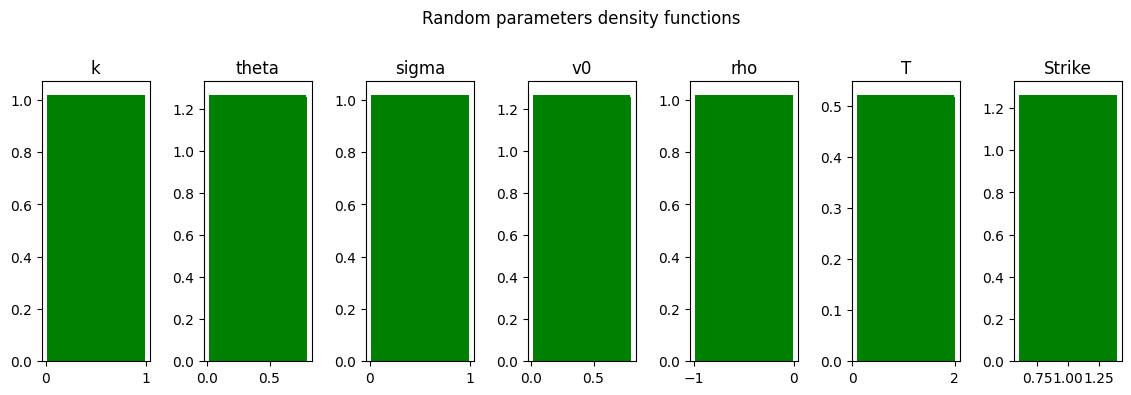

In [25]:
__tStart = time.perf_counter()
xDF = lhs_sampling(rand, NUM, bounds = bounds)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("LHS", __tEnd - __tStart) )

# Let's check the distribution of the parameters we have generated
histo_params( xDF, title = "Random parameters density functions")

**Generate random DB**

In [26]:
# Generate training/test set
__tStart = time.perf_counter()
df =  parms_gen( lhs = xDF, Xc=XC, strikes = strikes)
__tEnd = time.perf_counter()
print("@ %-34s: elapsed %.4f sec" %("GEN", __tEnd - __tStart) )

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:49<00:00, 201.84it/s]

@ Seq. pricing                      : elapsed 49.5561 sec
@ Info                              : Violations Put=5, Call=0 DB=9995 out of 10000
@ GEN                               : elapsed 49.5727 sec


In [27]:
df.head()

,k,theta,sigma,v0,rho,T,Strike,Price
0,0.182508,0.621737,0.309327,0.012488,-0.105088,0.276821,1.06028,0.073012
1,0.077369,0.103576,0.119840,0.638327,-0.925798,0.281996,1.04852,0.195589
2,0.120335,0.151608,0.280815,0.201773,-0.874714,0.834571,1.26716,0.329462
3,0.584250,0.608228,0.136274,0.054438,-0.758290,1.217329,1.23796,0.356562
4,0.257748,0.090778,0.336948,0.112028,-0.220918,1.421838,1.28684,0.345745


Select a random subset as a challenge set

In [28]:
X_train, X_test = train_test_split(df, test_size=0.33, random_state=42)

Add some noise to the training set

In [29]:
EPS = 0.0
# Add some noise to the training set
if EPS > 0.0:
    xl = np.min(X_train["Price"])
    xh = np.max(X_train["Price"])

    xi = rand.normal( loc = 0.0, scale = EPS*(xh-xl), size=X_train.shape[0])
    X_train["Price"] += xi

Display the amount of noise

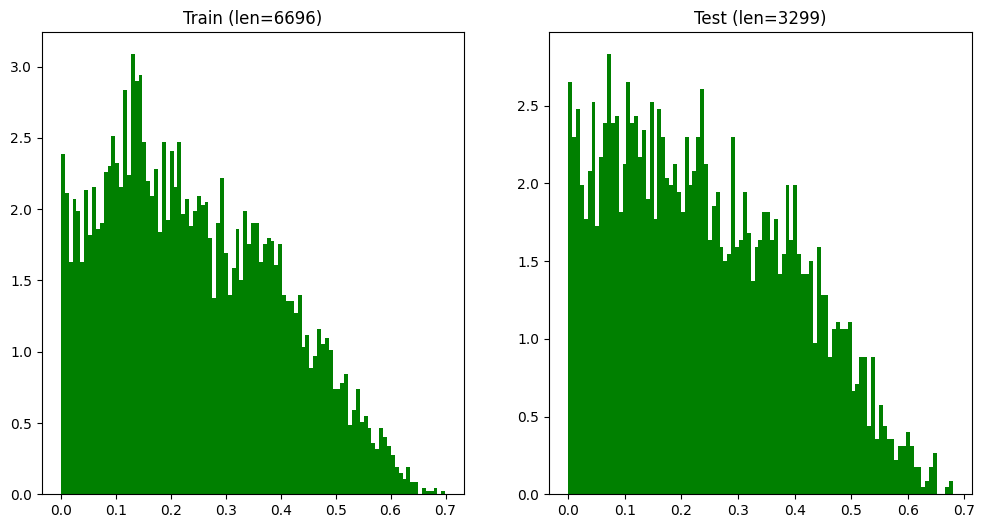

In [30]:
import warnings
warnings.simplefilter('ignore')
# Check the dispersion
if EPS > 0.0:
    xMin = 0.0
    xMax = max(X_train["Price"])
    v = np.arange(xMin, xMax, (xMax - xMin)/100.)

    fig, ax = plt.subplots(1,1, figsize=(12,6))

    ax.plot( X_train["Price"], X_train_n["Price"], ".", markersize=1)
    ax.plot( v, v, color="red")
    ax.set_title("Perturbed")
    ax.set_xlabel("X train")
    ax.set_ylabel("X train with noise")

    #figName = "scatter_%s.png" %(TAG)
    figName = "scatter_noise.png" 
    plt.savefig(figName, format="png")
    plt.show()
    histo_dict( {"Train"    : np.array(X_train["Price"]), 
                 "Test"     : np.array(X_test["Price"]), 
                 "Perturbed": np.array(X_train_n["Price"]) }, TAG=TAG)
else:
    histo_dict( {"Train": np.array(X_train["Price"]), "Test": np.array(X_test["Price"]) }, TAG=TAG )

remove the target from the test set

In [31]:
Y_test = pd.DataFrame({"Price": X_test["Price"]})
X_test = X_test.drop(columns="Price")

### Saving dataset to disk

write training set to disk

In [32]:
outputFile = "%s_%s.csv" %(outputPrfx, TAG)
outputFile = 'C:/data/' + outputFile
X_train.to_csv(outputFile, sep=',', float_format="%.6f", index=False)
print("@ %-34s: training data frame written to '%s'" %("Info", outputFile))
if verbose: print(outputFile); print(X_train)

@ Info                              : training data frame written to 'C:/data/full_10000_MCA.csv'


In [33]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(outputFile)    

write challenge set to disk

In [34]:
challengeFile = "%s_%s.csv" %(testPrfx, TAG)
challengeFile = 'C:/data/' + challengeFile
X_test.to_csv(challengeFile, sep=',', float_format="%.6f", index=False)
print("@ %-34s: challenge data frame written to '%s'" %("Info", challengeFile))
if verbose: print(challengeFile); print(X_test)

@ Info                              : challenge data frame written to 'C:/data/test_10000_MCA.csv'


In [35]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(challengeFile)    

write target to disk

In [36]:
targetFile = "%s_%s.csv" %(targetPrfx, TAG)
targetFile = 'C:/data/' + targetFile
Y_test.to_csv(targetFile, sep=',', float_format="%.6f", index=False)
print("@ %-34s: target data frame written to '%s'" %("Info", targetFile))
if verbose: print(targetFile); print(Y_test)

@ Info                              : target data frame written to 'C:/data/trgt_10000_MCA.csv'


In [37]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(targetFile)    